In [1]:
cd ..

/Users/ulfaslak/Dropbox/school/sem12/MScProject/Academic/code/pipeline_code


### Simulate structured data

In [2]:
from pareto_clustering.dependencies.matlab import generate_poisson_dataset
X_sim, labels_sim = generate_poisson_dataset.generate_poisson_dataset(4,100,100,0.0)

### Compute T-ratio matrix

In [8]:
from pareto_clustering.cluster.build_S import Build_S
_, T, _ = Build_S(X_sim,5,sample_size=1.0, remove_outliers=False).main(visualize=False)

0% 50/4950
10% 545/4950
20% 1040/4950
30% 1535/4950
40% 2030/4950
50% 2525/4950
60% 3020/4950
70% 3515/4950
80% 4010/4950
90% 4505/4950
100% 4950/4950


### Infer communities

In [11]:
from pareto_clustering.cluster import cluster_Infomap
pred_communities = cluster_Infomap.fit(T)

### Compare inferred communities to true communities

In [13]:
def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1 # j+1 instead of j since previous_row and current_row are one character longer
            deletions = current_row[j] + 1       # than s2
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

def flatten(l):
    return [item for sublist in l for item in sublist]

pred_communities_sorted = sorted(pred_communities.values(), key=lambda x: (x[0],x[-1]))

true_stringyfied = flatten([[str(i)]*v for i,v in enumerate(labels_sim)])
pred_stringyfied = flatten([[str(i)]*len(v) for i,v in enumerate(pred_communities_sorted)])

edit_distance = levenshtein(true_stringyfied, pred_stringyfied)

print "Edit distance:", edit_distance
print "Accuracy:", 100-edit_distance*0.5/len(pred_stringyfied)*100

Edit distance: 2
Accuracy: 99.0


/Users/ulfaslak/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


# Full pipeline in loop

In [1]:
cd ..

/Users/ulfaslak/Dropbox/school/sem12/MScProject/Academic/code/pipeline_code


In [85]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from pareto_clustering.dependencies.matlab import generate_poisson_dataset
from pareto_clustering.cluster.build_S import Build_S
from pareto_clustering.cluster import cluster_Infomap

In [144]:
glob_counter = 0
accuracy_arr = []

In [ ]:
def compute_accuracy(labels_sim, pred_communities):
    
    # Get true pairs
    true_pairs = set()

    for i in range(1, dim+1):
        for j in range(1, dim+1):
            if j <= i: continue
            true_pairs.add((i,j,0))

    for i,_ in enumerate(labels_sim):
        start_index = int(sum(labels_sim[:i]))
        v = range(start_index+1, start_index+int(labels_sim[i])+1)
        for i in v:
            for j in v:
                if j <= i: continue
                true_pairs.remove((i,j,0))
                true_pairs.add((i,j,1))


    # Compute get predicted pairs
    pred_pairs = set()

    for i in range(1, dim+1):
        for j in range(1, dim+1):
            if j <= i: continue
            pred_pairs.add((i,j,0))

    for k,v in pred_communities.items():
        for i in v:
            for j in v:
                if j <= i: continue
                pred_pairs.remove((i,j,0))
                pred_pairs.add((i,j,1))
    
    
    # Return number of intersections devided by number of pairs
    return len(pred_pairs & true_pairs) * 1.0/len(true_pairs)


def sample_points_in_simplex(simp, num_points, noise):
    d = simp.shape[1]
    A = np.random.rand(d,num_points); A.sort(axis=0); A = A.T
    A = np.hstack([np.zeros((num_points,1)), A, np.ones((num_points,1))])
    A = A[:, range(1,d+2)] - A[:, range(d+1)]
    return np.dot(A,simp) + np.dot(noise,(np.random.rand(num_points,d)-0.5))


def generatePoissonDataset(lam, dimensions, num_points, noise, minsize=2):
    dtot = 0
    while dtot < dimensions:
        d = np.random.poisson(lam) + minsize
        
        if dtot+d >= dimensions-minsize:
            d = dimensions - dtot
        elif dtot+d > dimensions:
            d = dtot - dimensions
            
        if 'A' in locals():
            A = np.hstack([A, sample_points_in_simplex(np.random.rand(d+1,d), num_points, noise)])
            div.append(d)
        else:
            A = sample_points_in_simplex(np.random.rand(d+1,d), num_points, noise)
            div = [d]
            
        dtot += d
        
    return A, div


num_iter = 11
dim = 100
N = 1000

for noise_level in np.linspace(0,1,num_iter):
    
    print "simulating for noise level", noise_level
    if noise_level*10 < glob_counter:
        print "skipping"; continue
    
    # Generate data
    X_sim, labels_sim = generatePoissonDataset(4,dim,N,noise_level)
    
    # Compute T-matrix
    _, T, _ = Build_S(X_sim,5,sample_size=1.0, remove_outliers=False).main(visualize=False)
    
    # Find communities
    pred_communities = cluster_Infomap.fit(T)
    
    # Compute accuracy
    accuracy = compute_accuracy(labels_sim, pred_communities)
    accuracy_arr.append(accuracy)
    
    glob_counter += 1

simulating for noise level 0.0
0% 50/4950
10% 545/4950

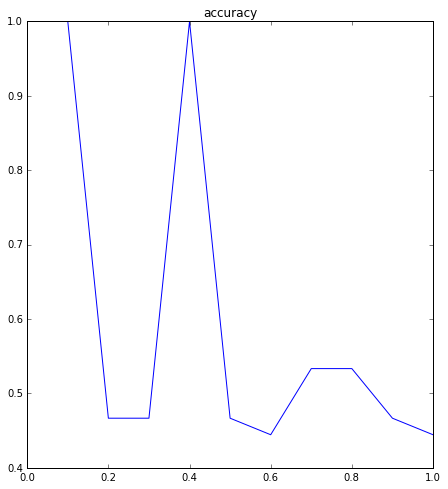

In [142]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,2)
plt.title("accuracy")
plt.plot(np.linspace(0,1,11),accuracy_arr)

plt.show()

In [123]:
def sample_points_in_simplex(simp, num_points, noise):
    d = simp.shape[1]
    A = np.random.rand(d,num_points); A.sort(axis=0); A = A.T
    A = np.hstack([np.zeros((num_points,1)), A, np.ones((num_points,1))])
    A = A[:, range(1,d+2)] - A[:, range(d+1)]
    return np.dot(A,simp) + np.dot(noise,(np.random.rand(num_points,d)-0.5))


def generatePoissonDataset(lam, dimensions, num_points, noise, minsize=2):
    dtot = 0
    while dtot < dimensions:
        d = np.random.poisson(lam) + minsize
        
        if dtot+d >= dimensions-minsize:
            d = dimensions - dtot
        elif dtot+d > dimensions:
            d = dtot - dimensions
            
        if 'A' in locals():
            A = np.hstack([A, sample_points_in_simplex(np.random.rand(d+1,d), num_points, noise)])
            div.append(d)
        else:
            A = sample_points_in_simplex(np.random.rand(d+1,d), num_points, noise)
            div = [d]
            
        dtot += d
        
    return A, div

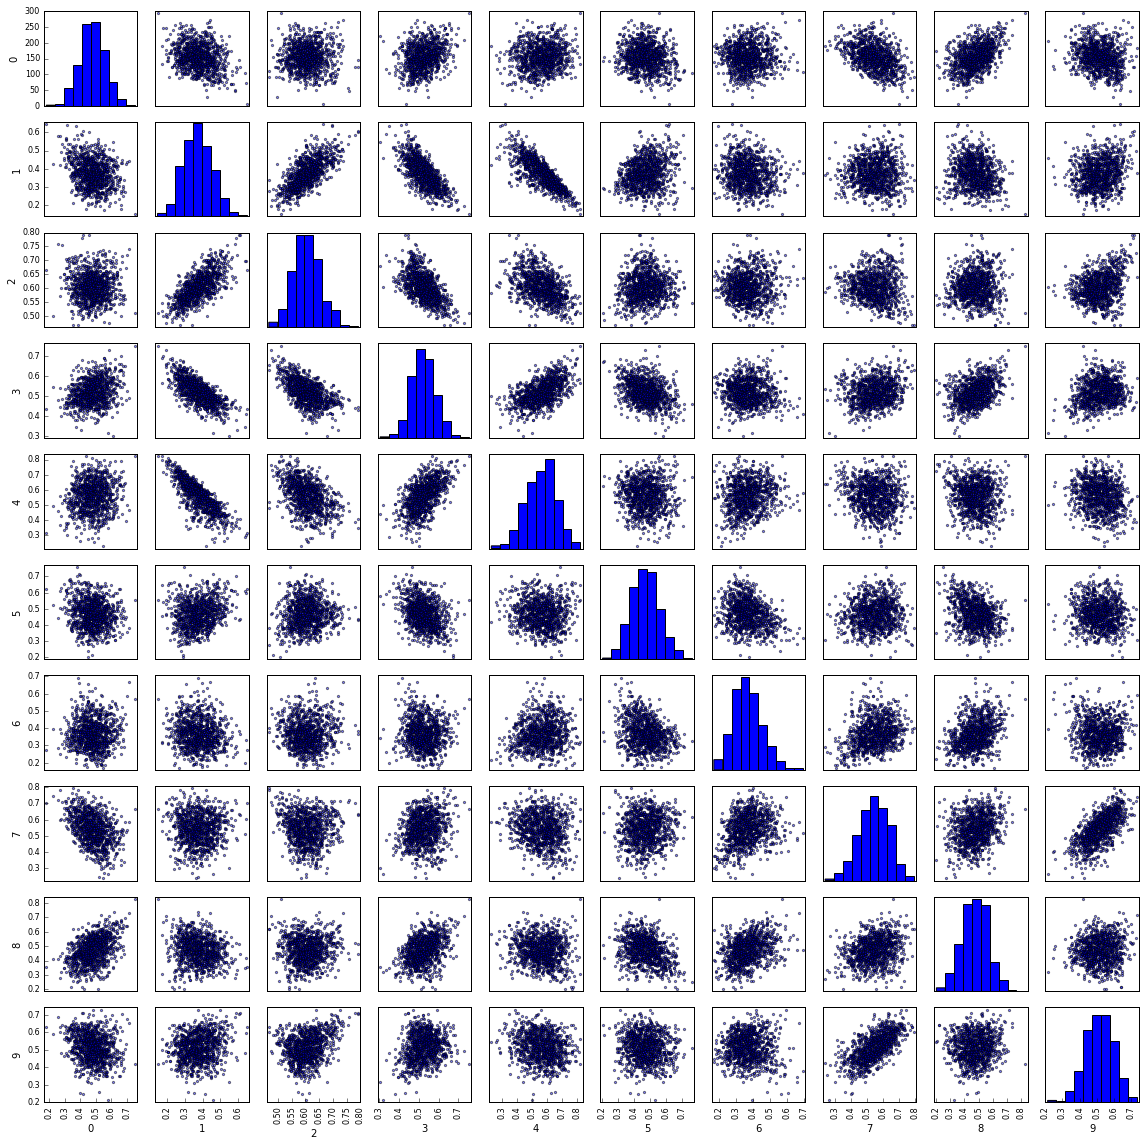

In [134]:
import pandas as pd
X_sim, labels_sim = generatePoissonDataset(4,10,1000,0)
df = pd.DataFrame(X_sim)
pd.tools.plotting.scatter_matrix(df, figsize=(16,16))
plt.tight_layout()

In [135]:
labels_sim

[10]

In [94]:
np.hstack([tmp1,tmp2])

array([[1, 4],
       [2, 5],
       [3, 6]])

In [104]:
np.random.rand()

array([ 0.04419866,  0.68376081])

In [115]:
range(2,7)

[2, 3, 4, 5, 6]

In [107]:
tmp1.sort(axis=0)

In [114]:
np.hstack([np.ones((5,1)),np.ones((5,1)),np.ones((5,1))])

array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.]])